# Music Genre Classification

This notebook explores various machine learning models to classify music genres based on audio features.

## Dataset

The dataset used in this notebook is the "Music Genre Classification" dataset from Kaggle, which contains audio features and corresponding genre labels for a large collection of songs.

## Notebook Overview

The notebook follows a standard machine learning workflow:

1.  **Data Loading and Initial Exploration**: The raw data is loaded, and basic information about the dataset, including column types, missing values, and descriptive statistics, is examined.
2.  **Data Preprocessing**:
    *   Irrelevant columns ('Artist Name', 'Track Name') are removed.
    *   The 'duration_in min/ms' column is converted to seconds and renamed.
    *   Duplicate records are identified and removed.
3.  **Univariate Analysis**: Histograms and box plots are used to visualize the distribution and identify outliers in each feature.
4.  **Handling Missing Values**: Missing values in 'popularity', 'instrumentalness', and 'key' are imputed using appropriate strategies (mean, median, or a specific value).
5.  **Outlier Removal**: Outliers are handled using the IQR method to clip extreme values.
6.  **Feature Transformation**: Logarithmic transformation is applied to skewed features ('speechiness', 'acousticness', 'liveness', 'instrumentalness', 'duration_in_min_sg') to achieve a more normal distribution.
7.  **Class Distribution Analysis**: The distribution of music genres (classes) is analyzed, revealing class imbalance.
8.  **Feature Engineering**:
    *   Correlation analysis is performed to understand relationships between features and the target variable.
    *   Features with zero variance and high collinearity are removed.
    *   A subset of potentially useful features for prediction is selected.
9.  **Data Splitting**: The dataset is split into training, validation, and test sets while maintaining the original class distribution using stratification.
10. **Handling Class Imbalance**: SMOTE (Synthetic Minority Over-sampling Technique) is applied to the training data to balance the class distribution.
11. **Feature Scaling**: Features are standardized using StandardScaler to ensure all features have a similar scale.
12. **Model Training and Evaluation**:
    *   **Logistic Regression**: Hyperparameter tuning is performed to select the optimal 'C' value. The model is trained on the balanced and scaled training data and evaluated on the test set using classification reports, confusion matrices, and ROC curves.
    *   **Decision Tree**: Hyperparameter tuning is performed to select optimal parameters. The model is trained and evaluated similarly to Logistic Regression.
    *   **Support Vector Machine (SVC)**: Hyperparameter tuning is performed to select the optimal 'C' value and kernel. The model is trained and evaluated similarly to the other models.
13. **Performance Comparison**: The performance of the three models is compared using classification reports, confusion matrices, and ROC curves to identify the best-performing model for this task.

## Models Evaluated

*   **Logistic Regression**: A linear model for classification.
*   **Decision Tree**: A tree-based model that partitions the data based on features.
*   **Support Vector Machine (SVC)**: A powerful model that finds an optimal hyperplane to separate classes.

## Results

The evaluation results show that **SVC** generally outperforms Logistic Regression and Decision Tree in terms of overall accuracy and F1-scores across most music genres, particularly for classes 0, 3, 4, and 7. Class 7 is consistently well-predicted by all models. However, all models struggle with predicting Class 1.

## Recommendations

*   **Prioritize SVC** for music genre classification based on the current analysis.
*   Further investigate **Class 1** to understand the reasons for poor performance and explore potential solutions like collecting more data for this class or trying different feature engineering techniques.
*   Consider applying **class balancing techniques** or **weight adjustments** to improve the performance of Logistic Regression and Decision Tree for underperforming classes.

In [1]:
!pip install rich

In [2]:
import numpy as np
import pandas as pd
from pandas.core.dtypes.api import is_numeric_dtype, is_string_dtype, is_categorical_dtype
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from google.colab import files

from sklearn.naive_bayes import GaussianNB as G, MultinomialNB as M, BernoulliNB as B
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
import graphviz, pickle

import os, pathlib, PIL, random, zipfile, cv2
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
from yellowbrick.classifier import ClassificationReport, ClassPredictionError, ConfusionMatrix, ROCAUC

from scipy.stats import shapiro

from sklearn.preprocessing import StandardScaler

In [3]:
from rich.console import Console
console = Console()

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("purumalgi/music-genre-classification")

console.print("Path to dataset files:", path)

100%|██████████| 1.29M/1.29M [00:00<00:00, 24.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/purumalgi/music-genre-classification/versions/1

In [5]:
df_submmission_original = pd.read_csv(f"/{path}/submission.csv",header=0,sep=',')
df_test_data_original = pd.read_csv(f"/{path}/test.csv",header=0,sep=',')
df_train_data_original = pd.read_csv(f"/{path}/train.csv",header=0,sep=',')

console.print("Shape Datasets:")
console.print(df_submmission_original.shape)
console.print(df_test_data_original.shape)
console.print(df_train_data_original.shape)

Shape Datasets:

(7713, 11)

(7713, 16)

(17996, 17)

## **Understanding the dataset**

In [6]:
df_train_data_original.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


| Nº | Variable | Type | Values / Range | Description |
|---|---|---|---|---|
| 0 | **Popularity** | float64 | 0 – 100 (approx.) | The estimated popularity of the song, often based on plays. |
| 1 | **danceability** | float64 | 0.0 – 1.0 | Measures how suitable a track is for dancing, considering factors like **tempo**, **rhythmic stability**, and **overall regularity**. A higher value means it's easier to dance to. |
| 2 | **energy** | float64 | 0.0 – 1.0 | Reflects the intensity and activity of a track. Energetic songs often sound fast, loud, and noisy. Think death metal (high energy) versus a mellow classical piece (low energy). It considers elements like **dynamic range**, **perceived loudness**, and **timbre**. |
| 3 | **key** | float64 | 0 – 11 | The musical key of the track. Numbers correspond to specific pitches (e.g., 0 = C, 1 = C♯/D♭). A value of -1 means no key was detected. |
| 4 | **loudness** | float64 | Decibels (dB) | The average loudness of a track in decibels (dB). This is useful for comparing how loud different songs are. Typical values range from -60 to 0 dB. |
| 5 | **mode** | int64 | 0 = minor, 1 = major | The mode of the track indicates whether it's in a major (1) or minor (0) key, referring to the type of musical scale used. |
| 6 | **speechiness** | float64 | 0.0 – 1.0 | Quantifies the presence of spoken words. Values above 0.66 suggest mostly spoken word, 0.33-0.66 indicates a mix of music and speech (like rap), and below 0.33 means it's primarily instrumental. |
| 7 | **acousticness** | float64 | 0.0 – 1.0 | A confidence score (from 0.0 to 1.0) indicating how likely a track is to be acoustic. A value of 1.0 means it's highly confident the track is acoustic. |
| 8 | **instrumentalness** | float64 | 0.0 – 1.0 | Predicts whether a track contains vocals. Higher values mean it's more likely to be instrumental. "Ooh" and "aah" sounds are considered instrumental, while rap and spoken word are vocal. |
| 9 | **liveness** | float64 | 0.0 – 1.0 | Estimates if a track was recorded live. Higher values suggest the presence of an audience. |
| 10 | **valence** | float64 | 0.0 – 1.0 | Measures the emotional positivity conveyed by the music. High valence tracks sound happy or euphoric, while low valence tracks sound sad or angry. |
| 11 | **tempo** | float64 | bpm (beats per min) | The estimated tempo of the track in beats per minute (BPM), indicating its speed or pace. |
| 12 | **duration_in min/ms** | float64 | Minutes or milliseconds | The total duration of the song, expressed in milliseconds. |
| 13 | **time_signature** | int64 | 3, 4, 5... | The estimated time signature of the track, which defines how many beats are in each bar (e.g., 4 for 4/4 time). |
| 14 | **Class** | int64 | 0 – 9 | The target Class, representing the music genre as an integer. |

Source: https://developer.spotify.com/documentation/web-api/reference/get-audio-features

In [7]:
df_train_data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

**Observations:**
- Artist Name and Track Name that are not relevance
- Columns such as Popularity, key, instrumentalness have null values
- Key is the column with more null values
- All samples have at least one class

### **Delete columns that are not relevance**

In [8]:
df_music = df_train_data_original.copy()

In [9]:
df_music.describe()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
count,17568.000000,17996.000000,17996.000000,15982.000000,17996.000000,17996.000000,17996.000000,17996.000000,13619.000000,17996.000000,17996.000000,17996.000000,1.799600e+04,17996.000000,17996.000000
mean,44.512124,0.543433,0.662777,5.952447,-7.910660,0.636753,0.079707,0.247082,0.177562,0.196170,0.486208,122.623294,2.007445e+05,3.924039,6.695821
std,17.426928,0.166268,0.235373,3.196854,4.049151,0.480949,0.083576,0.310632,0.304048,0.159212,0.240195,29.571527,1.119891e+05,0.361618,3.206073
min,1.000000,0.059600,0.000020,1.000000,-39.952000,0.000000,0.022500,0.000000,0.000001,0.011900,0.018300,30.557000,5.016500e-01,1.000000,0.000000
25%,33.000000,0.432000,0.509000,3.000000,-9.538000,0.000000,0.034800,0.004300,0.000089,0.097500,0.297000,99.620750,1.663370e+05,4.000000,5.000000
50%,44.000000,0.545000,0.700000,6.000000,-7.016000,1.000000,0.047400,0.081400,0.003910,0.129000,0.481000,120.065500,2.091600e+05,4.000000,8.000000
75%,56.000000,0.659000,0.860000,9.000000,-5.189000,1.000000,0.083000,0.434000,0.200000,0.258000,0.672000,141.969250,2.524900e+05,4.000000,10.000000
max,100.000000,0.989000,1.000000,11.000000,1.355000,1.000000,0.955000,0.996000,0.996000,1.000000,0.986000,217.416000,1.477187e+06,5.000000,10.000000


In [10]:
df_music.drop(["Artist Name", "Track Name"], axis=1, inplace=True)

In [11]:
df_music["duration_in min/ms"] = df_music["duration_in min/ms"] / 1000
df_music.rename(columns={"duration_in min/ms": "duration_in min/sg"}, inplace=True)

In [12]:
df_music.describe()

,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/sg,time_signature,Class
count,17568.000000,17996.000000,17996.000000,15982.000000,17996.000000,17996.000000,17996.000000,17996.000000,13619.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000,17996.000000
mean,44.512124,0.543433,0.662777,5.952447,-7.910660,0.636753,0.079707,0.247082,0.177562,0.196170,0.486208,122.623294,200.744459,3.924039,6.695821
std,17.426928,0.166268,0.235373,3.196854,4.049151,0.480949,0.083576,0.310632,0.304048,0.159212,0.240195,29.571527,111.989127,0.361618,3.206073
min,1.000000,0.059600,0.000020,1.000000,-39.952000,0.000000,0.022500,0.000000,0.000001,0.011900,0.018300,30.557000,0.000502,1.000000,0.000000
25%,33.000000,0.432000,0.509000,3.000000,-9.538000,0.000000,0.034800,0.004300,0.000089,0.097500,0.297000,99.620750,166.337000,4.000000,5.000000
50%,44.000000,0.545000,0.700000,6.000000,-7.016000,1.000000,0.047400,0.081400,0.003910,0.129000,0.481000,120.065500,209.160000,4.000000,8.000000
75%,56.000000,0.659000,0.860000,9.000000,-5.189000,1.000000,0.083000,0.434000,0.200000,0.258000,0.672000,141.969250,252.490000,4.000000,10.000000
max,100.000000,0.989000,1.000000,11.000000,1.355000,1.000000,0.955000,0.996000,0.996000,1.000000,0.986000,217.416000,1477.187000,5.000000,10.000000


**Observations:**
- All columns are numeric
- Columns have multiple ranges, so it is good to apply standardization
- The range of multiple columns is between 0 and 1. ('danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness','valence')
- Mode can be either 0 or 1

In [13]:
# column names standardization
df_music.columns = df_music.columns.str.lower().str.replace(' ', '_').str.replace('/', '_')
df_music.columns

Index(['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_in_min_sg', 'time_signature', 'class'],
      dtype='object')

### **Duplicate Records**

In [14]:
console.print(f"Number of duplicate records: {df_music.duplicated().sum()}")
df_music.drop_duplicates(inplace=True)
print(f"Number of duplicate records: {df_music.duplicated().sum()}")

Number of duplicate records: 41

Number of duplicate records: 0


## **Univariate analysis**

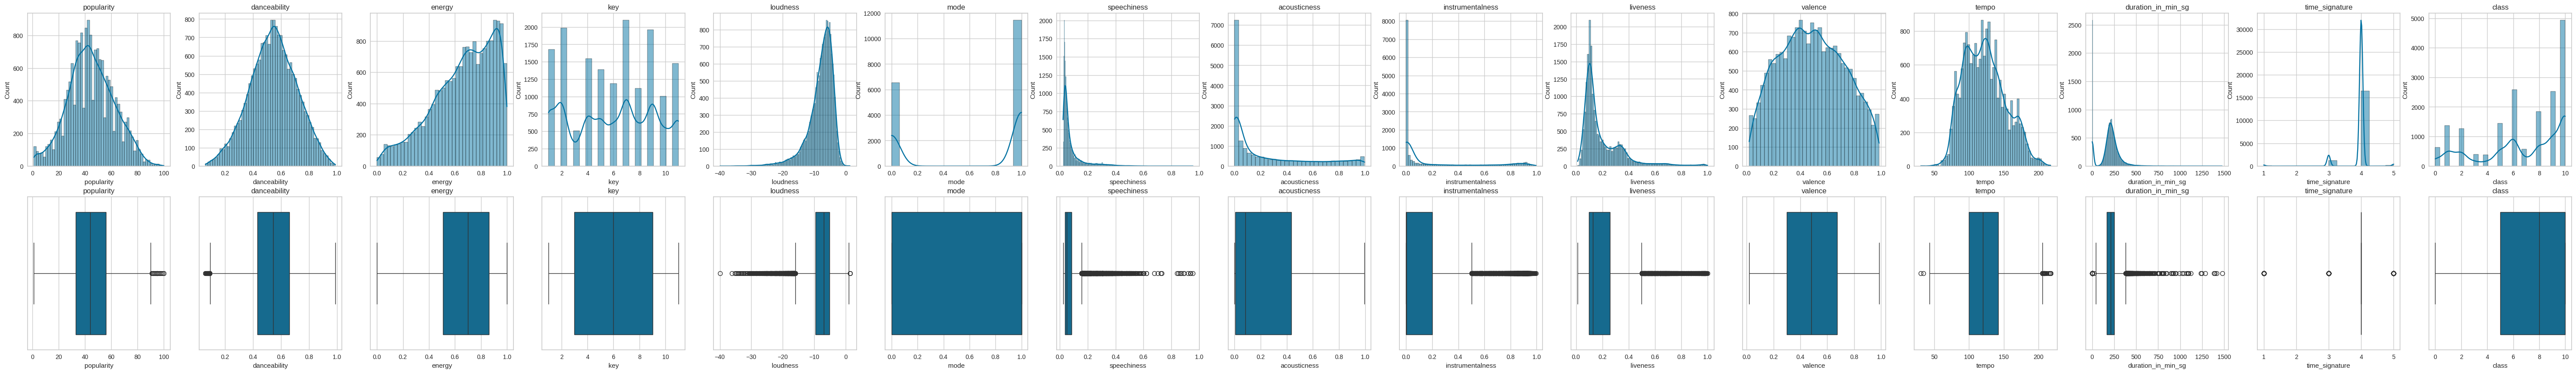

In [15]:
columns = df_music.columns
fig, ax = plt.subplots(2, len(columns), figsize=(5 * len(columns), 10))
for i, c in enumerate(columns):
  sns.histplot(df_music[c], kde=True, ax=ax[0, i]); ax[0, i].set_title(c)
  sns.boxplot(x=df_music[c], ax=ax[1, i]); ax[1, i].set_title(c)
plt.show()

**Observaciones:**
- Popularity, danceability, valence, and tempo show a normal distribution.
- Energy and loudness are skewed to the left.
- Speech, acoustics, instrumentality, and liveliness are skewed to the right; most values ​​are concentrated in a small data range.
- Key and class are multimodal.
- There are many outliers in each column.

### **Impute Null Values**

In [16]:
console.print("\nNull values per column:")
console.print(df_music.isnull().sum())

# Fill null values with the mean (good for normally distributed data)
columns_to_fill_mean = ['popularity']
for col in columns_to_fill_mean:
  df_music[col].fillna(df_music[col].mean(), inplace=True)

# Fill null values with the median (good for skewed data and outliers)
columns_to_fill_median = ['instrumentalness']
for col in columns_to_fill_median:
  df_music[col].fillna(df_music[col].median(), inplace=True)

# 'key' if -1 represents no key detected,
df_music['key'].fillna(-1, inplace=True) # If -1 represents no key

console.print("\nNull values after handling:")
console.print(df_music.isnull().sum())

Null values per column:

popularity             428
danceability             0
energy                   0
key                   2010
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4366
liveness                 0
valence                  0
tempo                    0
duration_in_min_sg       0
time_signature           0
class                    0
dtype: int64

<ipython-input-16-4547bc6f3be8>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_music[col].fillna(df_music[col].mean(), inplace=True)
<ipython-input-16-4547bc6f3be8>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)',

Null values after handling:

popularity            0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
duration_in_min_sg    0
time_signature        0
class                 0
dtype: int64

### **Remove Outliers**

In [17]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

num_cols = [c for c in df_music.columns if is_numeric_dtype(df_music[c])]
for col in df_music.columns:
    df_music = remove_outliers_iqr(df_music, col)

### **Charts after removing outliers**

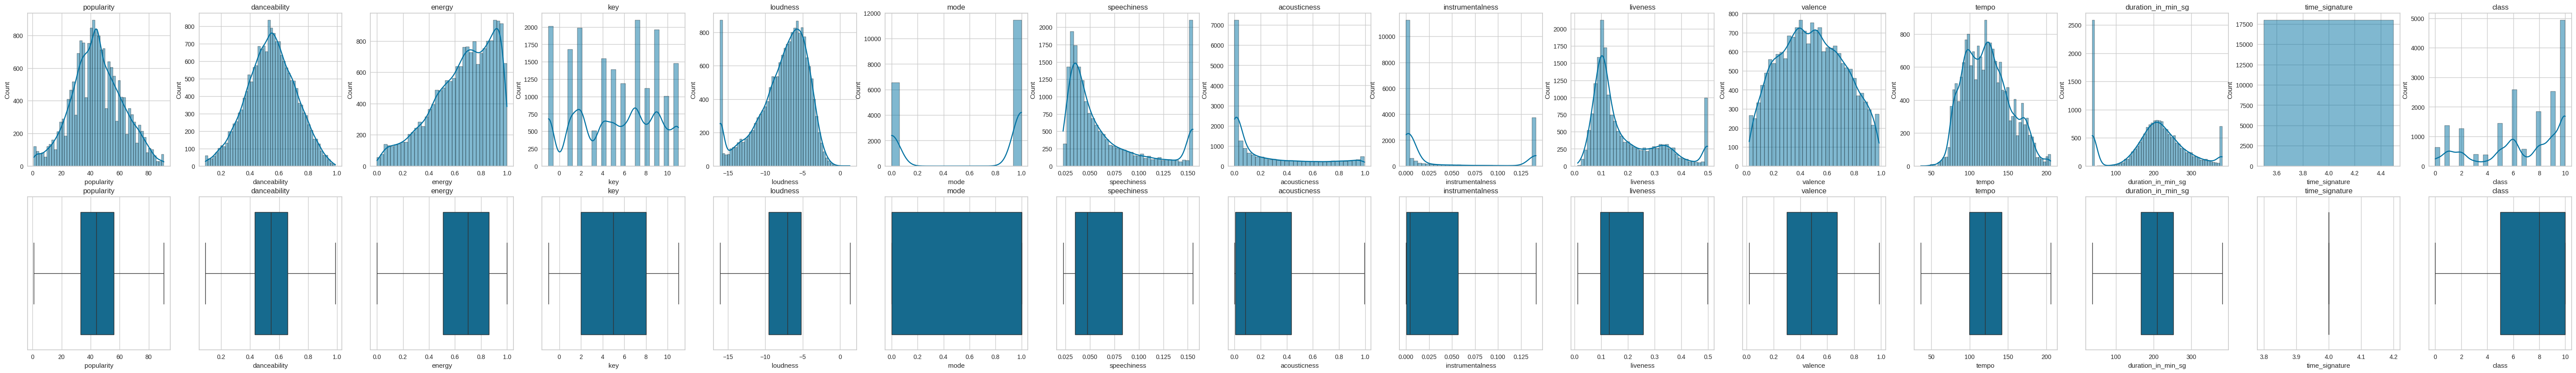

In [18]:
columns = df_music.columns
fig, ax = plt.subplots(2, len(columns), figsize=(5 * len(columns), 10))
for i, c in enumerate(columns):
  sns.histplot(df_music[c], kde=True, ax=ax[0, i]); ax[0, i].set_title(c)
  sns.boxplot(x=df_music[c], ax=ax[1, i]); ax[1, i].set_title(c)
plt.show()

**Observations:**
- After removing outliers, loudness and duration are more normal
- Time signatue is uniform

Due to the right skew or asymmetry shown in some columns **(speechiness, acousticness, liveness, instrumentalness)** we decided to apply the **logarithm** to transform and found that it looks more like a normal distribution.
We can also apply the **logarithm** to the column **duration** because it has a wide range

In [19]:
log_cols_transform = ['speechiness', 'acousticness', 'liveness', 'instrumentalness', 'duration_in_min_sg']

for col in log_cols_transform:
    df_music[f'{col}_log'] = np.log1p(df_music[col])

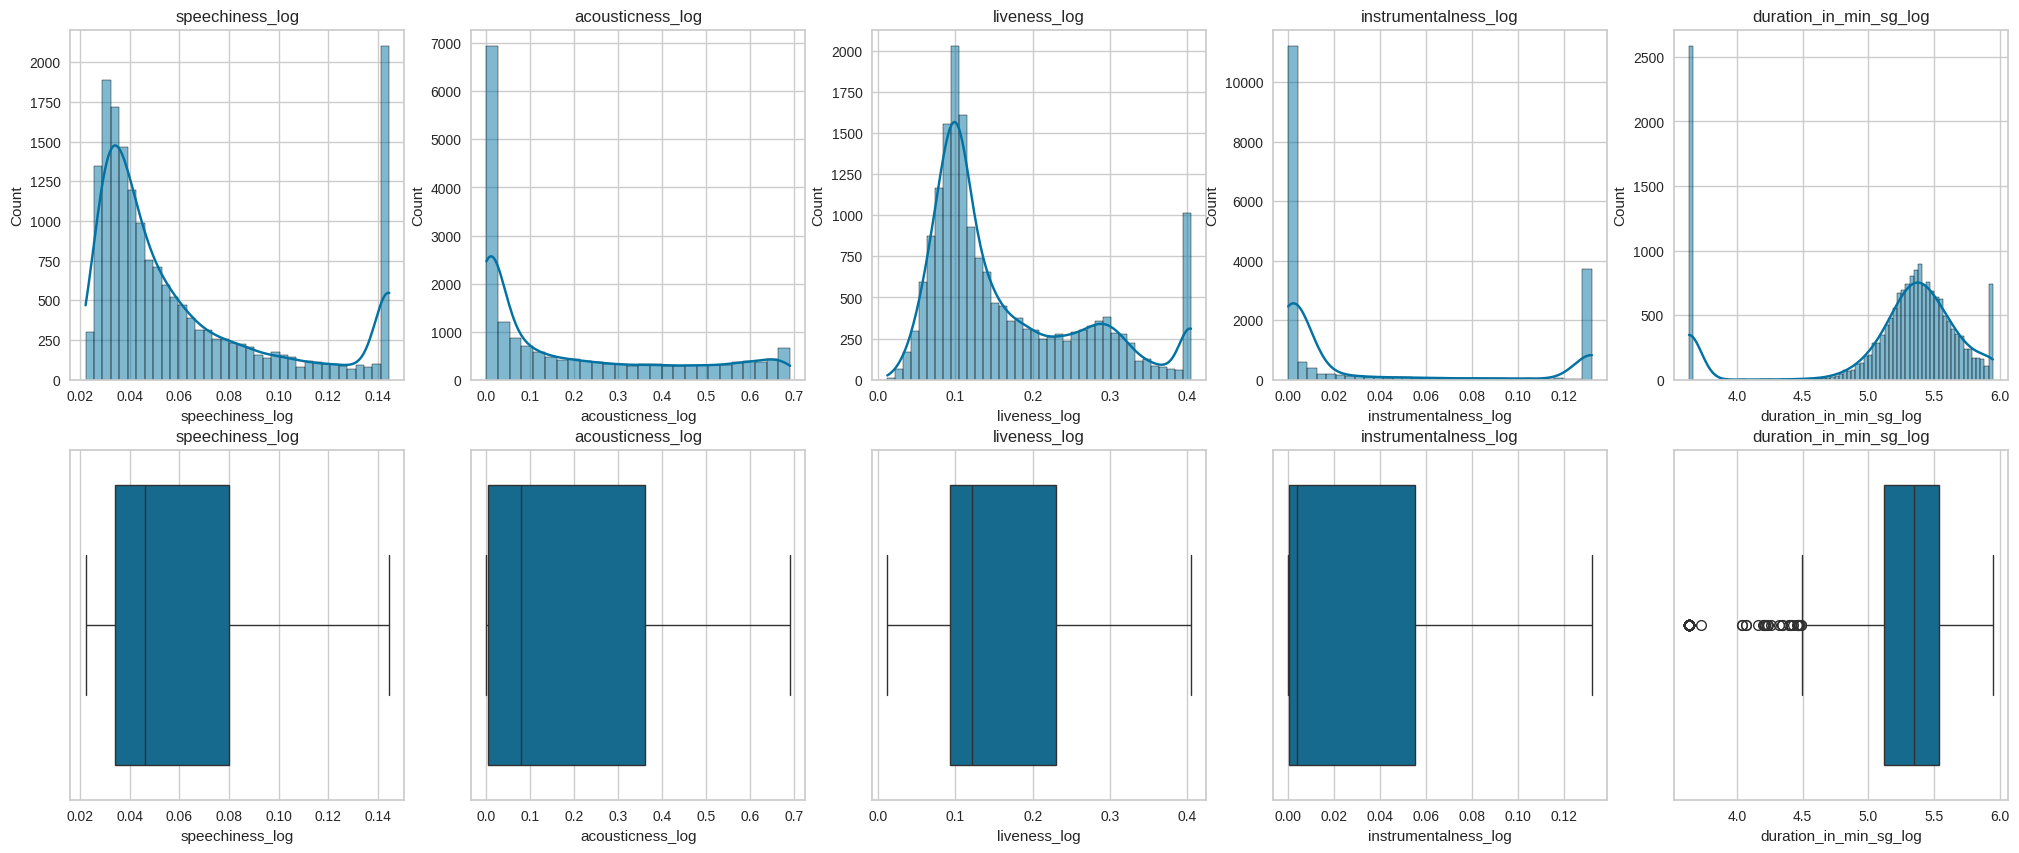

In [20]:
# Optional: Re-plot histograms and boxplots for transformed columns to check distribution
columns_after_log = log_cols_transform

fig, ax = plt.subplots(2, len(columns_after_log), figsize=(5 * len(columns_after_log), 10))

for i, col in enumerate(columns_after_log):
  sns.histplot(df_music[f'{col}_log'], kde=True, ax=ax[0, i]); ax[0, i].set_title(f'{col}_log')
  sns.boxplot(x=df_music[f'{col}_log'], ax=ax[1, i]); ax[1, i].set_title(f'{col}_log')
plt.show()

In [21]:
def more_normal(df, col1, col2):
    p1, p2 = shapiro(df_music[col1].dropna())[1], shapiro(df_music[col2].dropna())[1]
    return col1 if p1 > p2 else col2

In [22]:
log_variables = ['speechiness_log', 'acousticness_log', 'liveness_log', 'instrumentalness_log', 'duration_in_min_sg_log']
zip_variable = list(zip(log_cols_transform, log_variables))

for col1, col2 in zip_variable:
    console.print(f"More Normal: {more_normal(df_music, col1, col2)}")

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17955.
  res = hypotest_fun_out(*samples, **kwds)


More Normal: speechiness_log

More Normal: acousticness_log

More Normal: liveness_log

More Normal: instrumentalness_log

More Normal: duration_in_min_sg

The untransformed variable, duration_in_min_ms **exhibit distributions closer to normal than the log-transformed ones**. However, due to range issues, the transformed variables will be retained.

## Class distribution in the dataset (balance)

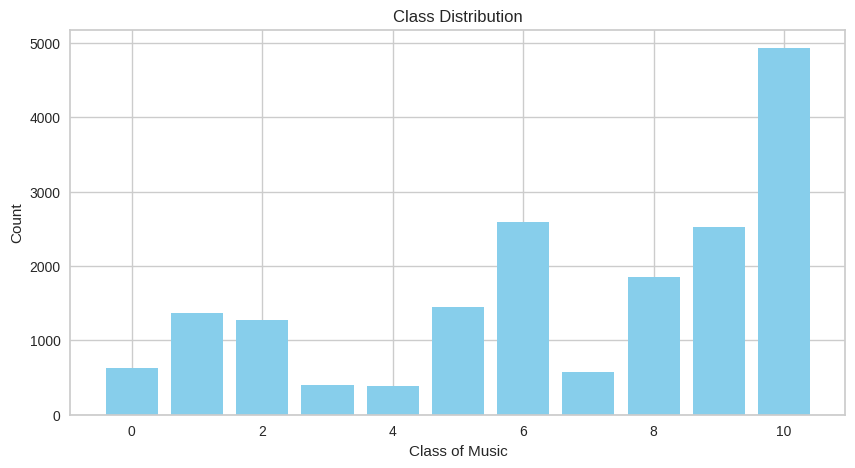

In [23]:
class_ = df_music.groupby('class').size()
labels = class_.index.values
sizes = class_.values

plt.figure(figsize=(10, 5))
plt.bar(labels, sizes, color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class of Music')
plt.ylabel('Count')
plt.show()

**Observations:**
- We can observe **imbalanced data**
- If a machine learning model is trained on **imbalanced data**, it tends to be biased toward the majority class. This means it may misclassify most examples in the minority class, as it has few examples from which to "learn" its patterns. This results in poor model performance when detecting the most critical or "rare" cases.

## **Feature Engineering**

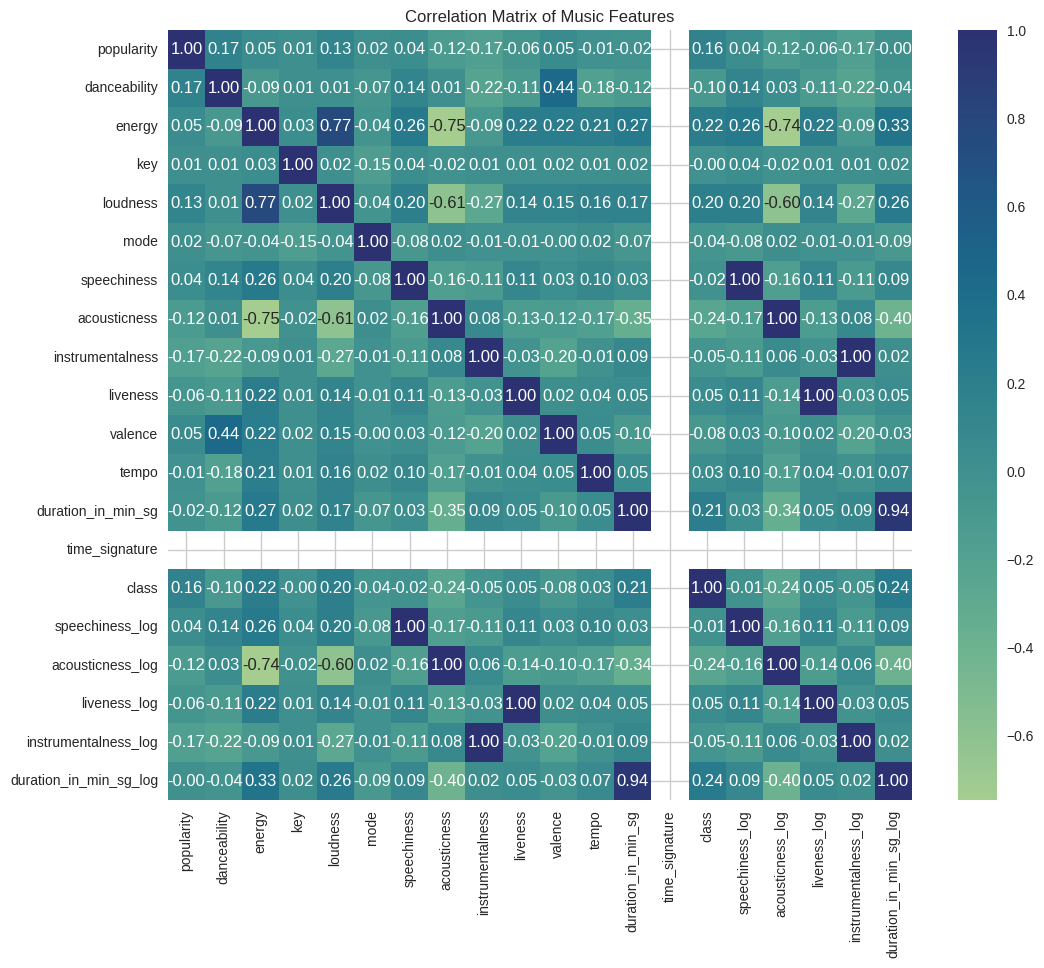

In [24]:
correlation_matrix = df_music.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='crest', fmt=".2f")
plt.title('Correlation Matrix of Music Features')
plt.show()

**Useful Features for Prediction**

- Duration (raw and log) is positively correlated with class, suggesting longer (or logarithmically transformed) track durations are associated with one of the classes.

- Instrumentalness (both raw and log) is also a good predictor — instrumental tracks might be more likely to belong to a particular class.

- Speechiness_log shows a moderate correlation and may be beneficial for some class distinctions.



In [25]:
df_music.drop(log_cols_transform, axis=1, inplace=True)
df_music.head()

,popularity,danceability,energy,key,loudness,mode,valence,tempo,time_signature,class,speechiness_log,acousticness_log,liveness_log,instrumentalness_log,duration_in_min_sg_log
0,60.0,0.854,0.564,1.0,-4.964,1,0.8990,134.071,4,5,0.047361,0.016955,0.081488,0.003912,5.462118
1,54.0,0.382,0.814,3.0,-7.230,1,0.5690,116.454,4,10,0.039797,0.001099,0.096219,0.004002,5.532334
2,35.0,0.434,0.614,6.0,-8.334,1,0.7870,147.681,4,6,0.051168,0.396088,0.332177,0.000196,4.706526
3,66.0,0.853,0.597,10.0,-6.528,0,0.5690,107.033,4,5,0.054015,0.020978,0.115113,0.003912,5.164603
4,53.0,0.167,0.975,2.0,-4.279,1,0.0918,199.060,4,10,0.144468,0.000169,0.158712,0.015972,5.442245


### **Zero Variance**

In [26]:
df_music.nunique()

,0
popularity,92
danceability,880
energy,1208
key,12
loudness,8243
mode,2
valence,1320
tempo,13532
time_signature,1
class,11


In [27]:
columns_removed = df_music.columns[df_music.nunique() == 1].tolist()
print("Columnas removing for variance:", columns_removed)
df_music = df_music.loc[:, df_music.nunique() > 1]

Columnas removing for variance: ['time_signature']


### **High collinearity**

In [28]:
upper_tri = df_music.corr().where(np.triu(np.ones(df_music.corr().shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.60)]
df_music = df_music.drop(columns=to_drop)
print("columns removing for high collinearity:", to_drop)

columns removing for high collinearity: ['loudness']


## **Featured Selected**

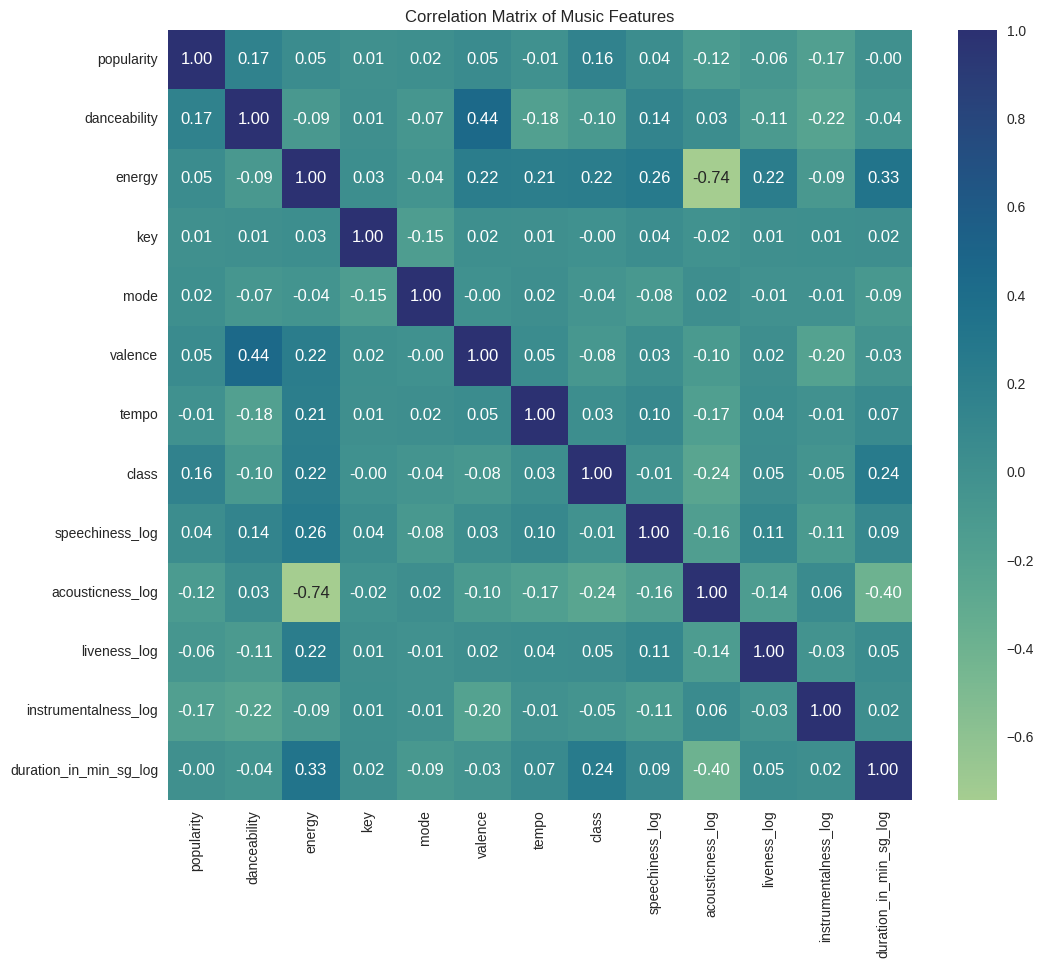

In [29]:
correlation_matrix = df_music.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='crest', fmt=".2f")
plt.title('Correlation Matrix of Music Features')
plt.show()

We believe to start with the top 6 features **popularity, energy,speechiness_log, acousticness_log, instrumentalness_log, duration_in_min_ms_log**

In [30]:
df_music.columns

Index(['popularity', 'danceability', 'energy', 'key', 'mode', 'valence',
       'tempo', 'class', 'speechiness_log', 'acousticness_log', 'liveness_log',
       'instrumentalness_log', 'duration_in_min_sg_log'],
      dtype='object')

In [31]:
df_music.drop(['energy', 'key', 'tempo'], axis=1, inplace=True)

In [32]:
df_music.columns

Index(['popularity', 'danceability', 'mode', 'valence', 'class',
       'speechiness_log', 'acousticness_log', 'liveness_log',
       'instrumentalness_log', 'duration_in_min_sg_log'],
      dtype='object')

## **Division: Train and Test Sets**

In [33]:
y = df_music["class"]
X = df_music.drop(columns=["class"])

In [34]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

In [36]:
console.print(f"Original Dataset: {df_music.shape}")
console.print(f"X Training: {X_train.shape}, y Training: {y_train.shape}")
console.print(f"X Validation: {X_val.shape}, y Validation: {y_val.shape}")
console.print(f"X Test: {X_test.shape}, y test: {y_test.shape}")


console.print("\nDistribución de clases en el set original:")
console.print(y.value_counts(normalize=True))
console.print("\nDistribución de clases en el set de entrenamiento:")
console.print(y_train.value_counts(normalize=True))
console.print("\nDistribución de clases en el set de validación:")
console.print(y_val.value_counts(normalize=True))
console.print("\nDistribución de clases en el set de prueba:")
console.print(y_test.value_counts(normalize=True))

Original Dataset: (17955, 10)

X Training: (10773, 9), y Training: (10773,)

X Validation: (3591, 9), y Validation: (3591,)

X Test: (3591, 9), y test: (3591,)

Distribución de clases en el set original:

class
10    0.274520
6     0.143915
9     0.140407
8     0.102980
5     0.080479
1     0.076246
2     0.070621
0     0.034809
7     0.032080
3     0.022389
4     0.021554
Name: proportion, dtype: float64

Distribución de clases en el set de entrenamiento:

class
10    0.274483
6     0.143878
9     0.140444
8     0.102943
5     0.080479
1     0.076209
2     0.070547
0     0.034809
7     0.032117
3     0.022464
4     0.021628
Name: proportion, dtype: float64

Distribución de clases en el set de validación:

class
10    0.274575
6     0.143971
9     0.140351
8     0.103035
5     0.080479
1     0.076302
2     0.070732
0     0.034809
7     0.032025
3     0.022278
4     0.021442
Name: proportion, dtype: float64

Distribución de clases en el set de prueba:

class
10    0.274575
6     0.143971
9     0.140351
8     0.103035
5     0.080479
1     0.076302
2     0.070732
0     0.034809
7     0.032025
3     0.022278
4     0.021442
Name: proportion, dtype: float64

### **Apply SMOTE for training data**

Original dataset shape Counter({10: 2957, 6: 1550, 9: 1513, 8: 1109, 5: 867, 1: 821, 2: 760, 0: 375, 7: 346, 3: 
242, 4: 233})

Resampled dataset shape Counter({10: 2957, 6: 2957, 8: 2957, 1: 2957, 7: 2957, 2: 2957, 5: 2957, 3: 2957, 4: 2957, 
9: 2957, 0: 2957})

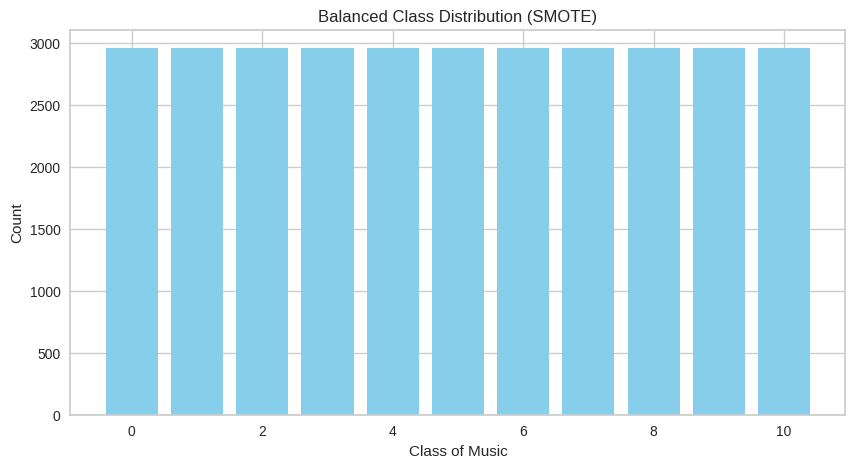

In [37]:
from imblearn.over_sampling import SMOTE
from collections import Counter

X = X_train
y = y_train

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

console.print("Original dataset shape %s" % Counter(y))
console.print("Resampled dataset shape %s" % Counter(y_resampled))

# Create a new DataFrame with the resampled data
df_music_balanced = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='class')], axis=1)

# Visualize the balanced class distribution
class_balanced = df_music_balanced.groupby('class').size()
labels_balanced = class_balanced.index.values
sizes_balanced = class_balanced.values

plt.figure(figsize=(10, 5))
plt.bar(labels_balanced, sizes_balanced, color='skyblue')
plt.title('Balanced Class Distribution (SMOTE)')
plt.xlabel('Class of Music')
plt.ylabel('Count')
plt.show()

**SMOTE (Synthetic Minority Over-sampling Technique)** is an oversampling technique used in machine learning to address the problem of imbalanced datasets in classification problems.

**How Does SMOTE Work?**
Unlike simply duplicating existing minority class instances (which can lead to overfitting), SMOTE generates new synthetic samples of the minority class. It does this by following these steps:

- **Select a minority instance:** SMOTE randomly picks an instance from the minority class.
- **Identify nearest neighbors:** It finds the "k" nearest neighbors to that instance (typically 5 neighbors).
- **Generate synthetic samples:** One of these "k" neighbors is randomly chosen. A new synthetic point is then created on the line connecting the original minority class instance to the selected neighbor. This new point is placed at a random distance between them.

This process is repeated until the desired balance between classes is achieved. By generating new synthetic samples, SMOTE helps to expand the variety of minority class examples, allowing the model to learn more general patterns and reduce the risk of overfitting.



In [38]:
X_train = X_resampled
y_train = y_resampled

console.print("Resampled dataset shape %s" % Counter(y_train))

Resampled dataset shape Counter({10: 2957, 6: 2957, 8: 2957, 1: 2957, 7: 2957, 2: 2957, 5: 2957, 3: 2957, 4: 2957, 
9: 2957, 0: 2957})

### **Standardization Variables**

In [39]:
scaler = StandardScaler()

standar_model = scaler.fit(X_train)

X_train_scaled = standar_model.transform(X_train)
X_test_scaled = standar_model.transform(X_test)
X_val_scaled = standar_model.transform(X_val)

X_train_stan_df = pd.DataFrame(X_train_scaled)
X_train_stan_df.columns = X_train.columns
X_train_stan_df.describe()

,popularity,danceability,mode,valence,speechiness_log,acousticness_log,liveness_log,instrumentalness_log,duration_in_min_sg_log
count,3.252700e+04,3.252700e+04,3.252700e+04,3.252700e+04,3.252700e+04,3.252700e+04,3.252700e+04,3.252700e+04,3.252700e+04
mean,1.310682e-16,3.355347e-16,6.990306e-17,-3.355347e-16,2.446607e-16,-2.516510e-16,-2.446607e-17,8.388367e-17,1.649712e-15
std,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00,1.000015e+00
min,-2.411475e+00,-2.891562e+00,-1.386434e+00,-2.000685e+00,-1.085415e+00,-1.120164e+00,-1.681203e+00,-7.139409e-01,-1.240792e+00
25%,-6.366548e-01,-6.417213e-01,-1.386434e+00,-7.845562e-01,-7.259756e-01,-9.922954e-01,-6.969928e-01,-6.867580e-01,-1.240792e+00
50%,5.037225e-02,1.640882e-02,7.212749e-01,-5.858469e-03,-4.256472e-01,-2.595614e-01,-4.074778e-01,-6.376049e-01,5.413553e-01
75%,6.801470e-01,6.613250e-01,7.212749e-01,7.809502e-01,3.955187e-01,9.983264e-01,5.051041e-01,6.614305e-01,8.159875e-01
max,2.712602e+00,2.869443e+00,7.212749e-01,2.166904e+00,2.330272e+00,1.685524e+00,2.851192e+00,1.867807e+00,1.392029e+00


**Select Standardization because:**

**Unknown or Non-Gaussian Distribution:** When the distribution of data is not known or does not follow a normal (Gaussian) pattern. For example in linear regression, we may want to normalize the dependent variable so it looks more like a bell curve, which allows for better confidence in our estimates.

## **Logistic Regression**

### Hyperparameter Selection

In [40]:
from sklearn.linear_model import LogisticRegression

C_vals = np.logspace(-3, 2, 25)

f = make_subplots(1, 1, subplot_titles=['Balanced'])

r = [((m := LogisticRegression(C=c, random_state=42, solver='lbfgs', class_weight='balanced').fit(X_val_scaled, y_val)).score(X_val_scaled, y_val), m.score(X_test_scaled, y_test)) for c in C_vals]
f.add_trace(go.Scatter(x=C_vals, y=[t for t,_ in r], mode='lines', name=f'train_balanced'), 1, 1)
f.add_trace(go.Scatter(x=C_vals, y=[u for _,u in r], mode='lines', name=f'val_balanced'), 1, 1)

f.update_xaxes(type='log', title='C')
f.update_yaxes(title='Accuracy')
f.show()

We selected **C=10** since it gives good precision and it is seen to be maintained, and it is also seen that there is no overfitting since training and testing behave the same.

### Create and train logistic regression

In [41]:
classification_log = LogisticRegression(C=10, solver='lbfgs', random_state=42)
classification_log.fit(X_train_scaled, y_train)

LogisticRegression(C=10, random_state=42)

### Test with training data

In [42]:
y_pred_log_train = classification_log.predict(X_train_scaled)
console.print(classification_report(y_train, y_pred_log_train,zero_division=True))

precision    recall  f1-score   support

           0       0.65      0.70      0.68      2957
           1       0.31      0.09      0.14      2957
           2       0.50      0.63      0.56      2957
           3       0.79      0.75      0.77      2957
           4       0.74      0.81      0.77      2957
           5       0.68      0.78      0.73      2957
           6       0.37      0.27      0.31      2957
           7       0.91      0.94      0.92      2957
           8       0.55      0.76      0.64      2957
           9       0.39      0.37      0.38      2957
          10       0.27      0.29      0.28      2957

    accuracy                           0.58     32527
   macro avg       0.56      0.58      0.56     32527
weighted avg       0.56      0.58      0.56     32527

#### **1. Overall Performance**
- **Accuracy (58%)**: The model correctly classifies just over half of instances, indicating **moderate performance with room for improvement**.
- **Macro Avg (F1 = 0.56)**: Confirms the model struggles to generalize evenly across all classes.
- **Weighted Avg (F1 = 0.56)**: Similar to macro, showing problematic classes significantly impact performance.

#### **2. Class-Specific Insights**
- **Top Performers (F1 > 0.75)**:
  - **Class 7 (F1 = 0.92)**: Outstanding precision (0.91) and recall (0.94).
  - **Classes 3, 4, 5 (F1 = 0.77, 0.77, 0.73)**: Good precision-recall balance.
- **Moderate Performers (F1 0.5–0.7)**:
  - **Classes 0, 2, 8 (F1 = 0.68, 0.56, 0.64)**: Acceptable recall but low precision (especially Class 2).
- **Critical Underperformers (F1 < 0.4)**:
  - **Classes 1, 6, 9, 10 (F1 = 0.14, 0.31, 0.38, 0.28)**:
    - **Class 1 (Recall = 9%)**: Model barely detects instances of this class.
    - **Class 10 (Precision = 27%)**: High false positive rate.

#### **3. Key Issues Identified**
- **Class Imbalance**: Despite equal support (2957 per class), low recall in Classes 1/10 suggests model ignores/confuses them.
- **Precision-Recall Trade-offs**:
  - **Class 8 (Recall = 76%, Precision = 55%)**: Captures true instances but with many false positives.
  - **Class 6 (Precision = 37%, Recall = 27%)**: High both false positives and negatives.

### Test with test data

In [43]:
y_pred_log_test = classification_log.predict(X_test_scaled)
console.print(classification_report(y_test, y_pred_log_test,zero_division=True))

precision    recall  f1-score   support

           0       0.63      0.58      0.60       125
           1       0.12      0.05      0.07       274
           2       0.27      0.56      0.37       254
           3       0.55      0.72      0.62        80
           4       0.44      0.81      0.57        77
           5       0.53      0.74      0.62       289
           6       0.37      0.23      0.28       517
           7       0.84      0.93      0.88       115
           8       0.40      0.73      0.52       370
           9       0.41      0.40      0.40       504
          10       0.49      0.29      0.36       986

    accuracy                           0.43      3591
   macro avg       0.46      0.55      0.48      3591
weighted avg       0.43      0.43      0.41      3591

Compared to the above, it is seen that in some like 1, 2, 3 the precision decreases and it is very reminiscent, which can lead to overfitting, however the overall precision is not so far from that of the training.

## **Decision Tree**

### Hyperparameter Selection

In [44]:
hp = [('max_leaf_nodes',range(2, 50, 5)),('max_depth',(2, 7)),('min_samples_leaf',range(1, 50, 5))]
fig = make_subplots(1,3,subplot_titles=[n.replace('_',' ').title() for n,_ in hp])

for i,(param,vals) in enumerate(hp,1):
    stats=[(m:=DecisionTreeClassifier(random_state=42, class_weight='balanced')
             .set_params(**{param:v})
             .fit(X_val_scaled, y_val),
            m.score(X_val_scaled, y_val),
            m.score(X_test_scaled, y_test)) for v in vals]
    fig.add_trace(go.Scatter(x=list(vals), y=[t for _,t,_ in stats], mode='lines', name='train'), 1, i)
    fig.add_trace(go.Scatter(x=list(vals), y=[u for _,_,u in stats], mode='lines', name='test'),  1, i)

fig.show()

We selected **min_samples_leaf = 40** because it performs the best and is the point where less overfitting begins to occur.

### Create and train Decision Tree

In [45]:
classification_tree = DecisionTreeClassifier(random_state=42, min_samples_leaf=40, class_weight='balanced').fit(X_train_scaled, y_train)

### Test with training data

In [46]:
y_pred_dt_train = classification_tree.predict(X_train_scaled)
console.print(classification_report(y_train, y_pred_dt_train, zero_division=True))

precision    recall  f1-score   support

           0       0.74      0.81      0.78      2957
           1       0.46      0.48      0.47      2957
           2       0.61      0.70      0.65      2957
           3       0.85      0.83      0.84      2957
           4       0.84      0.86      0.85      2957
           5       0.73      0.77      0.75      2957
           6       0.43      0.38      0.40      2957
           7       0.94      0.92      0.93      2957
           8       0.68      0.75      0.72      2957
           9       0.52      0.50      0.51      2957
          10       0.46      0.33      0.38      2957

    accuracy                           0.67     32527
   macro avg       0.66      0.67      0.66     32527
weighted avg       0.66      0.67      0.66     32527

### Test with test data

In [47]:
y_pred_dt_test = classification_tree.predict(X_test_scaled)
console.print(classification_report(y_test, y_pred_dt_test, zero_division=True))

precision    recall  f1-score   support

           0       0.58      0.54      0.56       125
           1       0.12      0.16      0.14       274
           2       0.29      0.42      0.34       254
           3       0.54      0.72      0.62        80
           4       0.48      0.69      0.56        77
           5       0.52      0.70      0.60       289
           6       0.33      0.25      0.29       517
           7       0.83      0.91      0.87       115
           8       0.44      0.64      0.52       370
           9       0.43      0.42      0.42       504
          10       0.45      0.25      0.32       986

    accuracy                           0.41      3591
   macro avg       0.45      0.52      0.48      3591
weighted avg       0.41      0.41      0.40      3591

## **Support Vector Machine**

### Hyperparameter Selection

In [48]:
from sklearn.svm import SVC

C_vals = np.logspace(-3, 2, 15)

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
titles = [f'{k or " - Balanced"}' for k in kernels]

f = make_subplots(rows=1, cols=4, subplot_titles=titles)


for c, k in enumerate(kernels, 1):
  res = [((m := SVC(kernel=k, C=cv, random_state=42, class_weight="balanced", verbose=1, tol=1e-4).fit(X_val_scaled, y_val)).score(X_val_scaled, y_val), m.score(X_test_scaled, y_test)) for cv in C_vals]
  f.add_trace(go.Scatter(x=C_vals, y=[t for t,_ in res], mode='lines', name=f'train_{k}_Balanced'), 1, c)
  f.add_trace(go.Scatter(x=C_vals, y=[u for _,u in res], mode='lines', name=f'val_{k}_Balanced'), 1, c)

  f.add_trace(go.Scatter(x=C_vals, y=[t for t,_ in r], mode='lines', name=f'train_balanced'), 1, 1)

f.update_xaxes(type='log', title='C')
f.update_yaxes(title='Accuracy')
f.update_layout(height=600, width=1100, showlegend=False)
f.show()

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

We selected **poly kernel and C=1** because it appears to have less overfitting and its accuracy is better.

### **Training**

In [49]:
clf_svc = SVC(C=0.1, random_state=42, kernel='poly', class_weight='balanced')
clf_svc.fit(X_train_scaled, y_train)

SVC(C=0.1, class_weight='balanced', kernel='poly', random_state=42)

### Test with training data

In [50]:
y_pred_svc_train = clf_svc.predict(X_train_scaled)
console.print(classification_report(y_train, y_pred_svc_train,zero_division=True))

precision    recall  f1-score   support

           0       0.68      0.85      0.76      2957
           1       0.33      0.45      0.38      2957
           2       0.53      0.67      0.59      2957
           3       0.90      0.77      0.83      2957
           4       0.78      0.82      0.80      2957
           5       0.76      0.76      0.76      2957
           6       0.45      0.23      0.31      2957
           7       0.95      0.94      0.94      2957
           8       0.65      0.69      0.67      2957
           9       0.46      0.44      0.45      2957
          10       0.37      0.24      0.29      2957

    accuracy                           0.62     32527
   macro avg       0.62      0.62      0.62     32527
weighted avg       0.62      0.62      0.62     32527

### Test with testing data

In [51]:
y_pred_svc_test = clf_svc.predict(X_test_scaled)
console.print(classification_report(y_test, y_pred_svc_test,zero_division=True))

precision    recall  f1-score   support

           0       0.65      0.73      0.68       125
           1       0.14      0.27      0.19       274
           2       0.30      0.57      0.39       254
           3       0.71      0.75      0.73        80
           4       0.47      0.83      0.60        77
           5       0.57      0.72      0.63       289
           6       0.42      0.24      0.30       517
           7       0.88      0.93      0.91       115
           8       0.49      0.64      0.55       370
           9       0.44      0.42      0.43       504
          10       0.56      0.28      0.38       986

    accuracy                           0.44      3591
   macro avg       0.51      0.58      0.53      3591
weighted avg       0.48      0.44      0.44      3591

## **Performance Comparison**

In [52]:
Clases = df_music.groupby('class').size()
classes, classifiers = list(Clases.index), [classification_log, classification_tree, clf_svc]
console.print(classes)
console.print(classifiers)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

[
    LogisticRegression(C=10, random_state=42),
    DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=40,
                       random_state=42),
    SVC(C=0.1, class_weight='balanced', kernel='poly', random_state=42)
]

### **Report**

### **Testing Dataset**

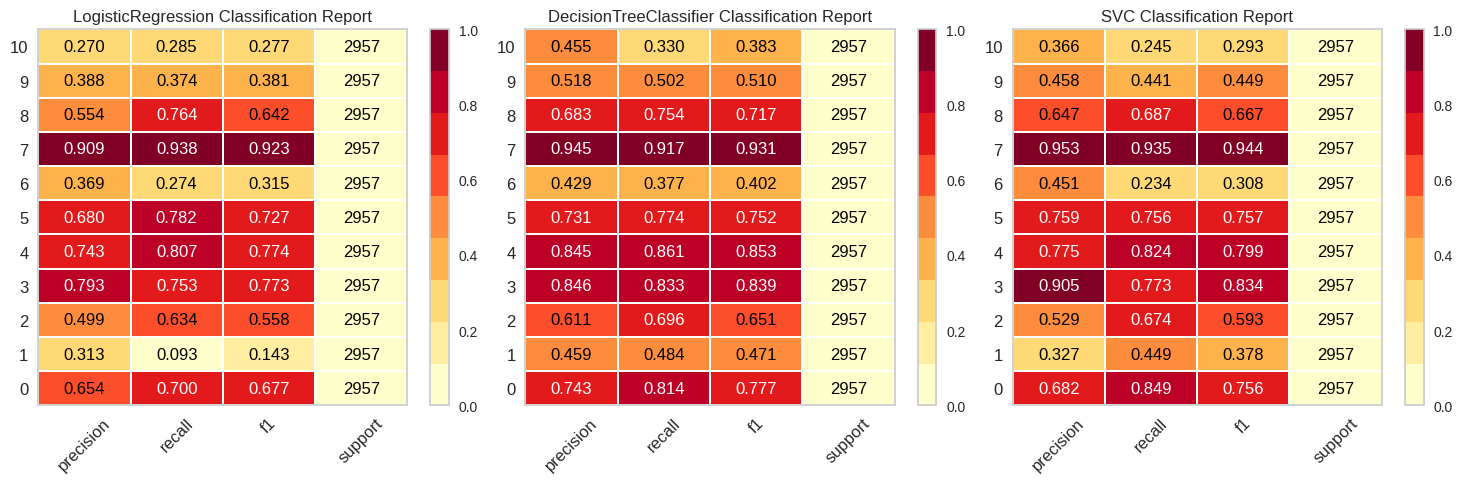

In [53]:
fig, axe = plt.subplots(ncols=3,nrows=1,figsize=(15, 5))
fig.tight_layout(pad=8.0)
visualgrid = [ClassificationReport(classifiers[0], classes=classes, support=True,ax=axe[0]),
              ClassificationReport(classifiers[1], classes=classes, support=True,ax=axe[1]),
              ClassificationReport(classifiers[2], classes=classes, support=True,ax=axe[2]),]
for viz in visualgrid:
  viz.fit(X_train_scaled, y_train)
  viz.score(X_train_scaled, y_train)
  viz.finalize()
fig.show()

### **Test Dataset**

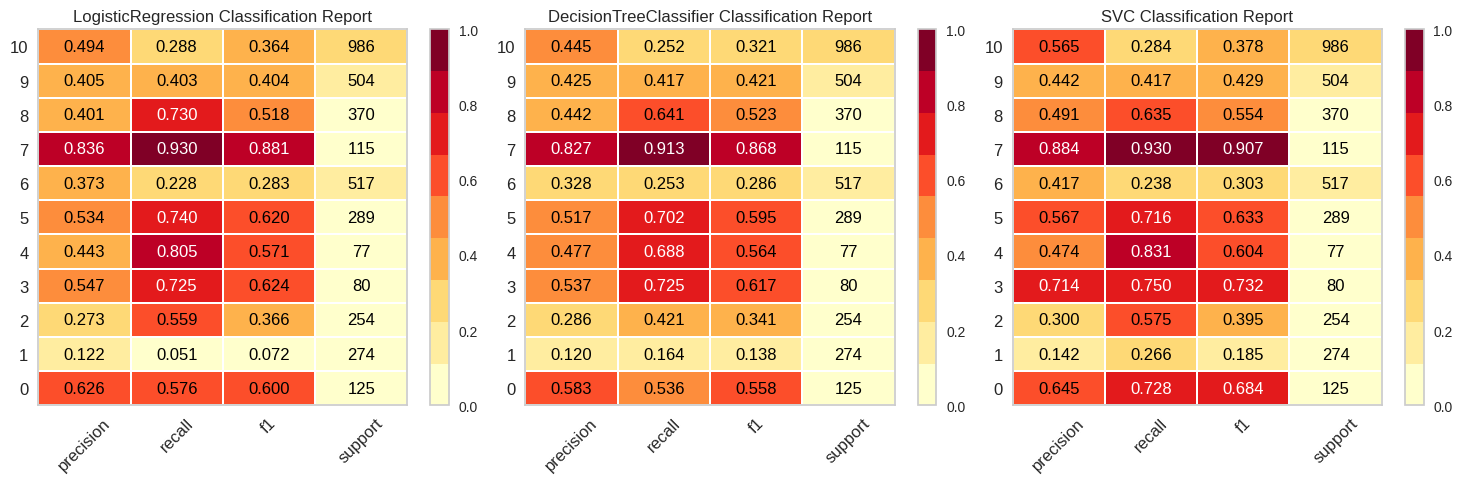

In [54]:
fig, axe = plt.subplots(ncols=3,nrows=1,figsize=(15, 5))
fig.tight_layout(pad=8.0)

visualgrid = [ClassificationReport(classifiers[0], classes=classes, support=True,ax=axe[0]),
              ClassificationReport(classifiers[1], classes=classes, support=True,ax=axe[1]),
              ClassificationReport(classifiers[2], classes=classes, support=True,ax=axe[2]),]

for viz in visualgrid:
  viz.fit(X_test_scaled, y_test)
  viz.score(X_test_scaled, y_test)
  viz.finalize()
fig.show()

**General Observations (Applicable to all models):**

1. **Overall Performance**:  
   - **SVC** shows the best overall performance in terms of precision, recall, and F1-score across multiple classes, especially for classes 7, 4, 3, and 0.  
   - **LogisticRegression** and **DecisionTreeClassifier** perform similarly in some classes, but SVC generally outperforms them.  

2. **Class 7 (Likely the Best-Performing Class)**:  
   - All models achieve high performance for this class, with F1-scores above 0.90. **SVC** is the best, followed closely by the other two models.  

3. **Underperforming Classes**:  
   - **Class 1**: All models struggle with this class, especially **LogisticRegression**.  **DecisionTreeClassifier** improves slightly, but it remains the worst-performing class.  
   - **Class 6**: Also shows low F1-scores across all models, with **LogisticRegression** performing the worst.  

4. **Overfitting or Bias**:  
   - Class 1 may be underrepresented in the dataset or inherently difficult to predict, leading to low recall and precision.  
   - **DecisionTreeClassifier** performs better than **LogisticRegression** for Class 1, suggesting it captures some relevant features, though performance is still suboptimal.  

5. **Consistency**:  
   - **SVC** is the most consistent, achieving high F1-scores across multiple classes, making it the most robust model.  
   - **LogisticRegression** has more variable performance, with some very low scores (e.g., Class 1) and moderate results elsewhere.  

6. **Recommendations**:  
   - Investigate why **Class 1** performs poorly—possible reasons include class imbalance or non-discriminative features.  
   - Consider techniques like data augmentation or hyperparameter tuning, especially for **LogisticRegression** and **DecisionTreeClassifier**.  
   - **SVC** is currently the best choice but could be further optimized for problematic classes.  

### Summary  
**SVC** is the most effective model based on these results, but all models require adjustments to improve performance in specific classes (e.g., 1 and 6).

### **Confusion Matrix**

### **Training Dataset**

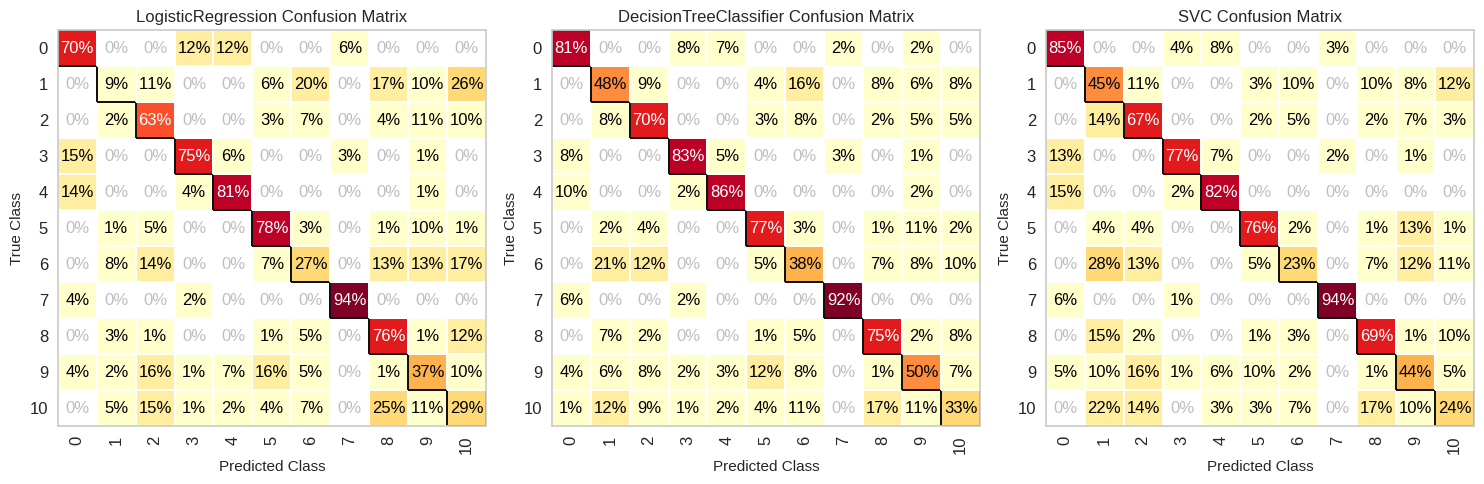

In [55]:
fig, axe = plt.subplots(ncols=3,nrows=1,figsize=(15, 5))
fig.tight_layout(pad=8.0)
visualgrid = [ConfusionMatrix(classifiers[0], classes=classes, support=True, percent=True, ax=axe[0]),
              ConfusionMatrix(classifiers[1], classes=classes, support=True, percent=True, ax=axe[1]),
              ConfusionMatrix(classifiers[2], classes=classes, support=True, percent=True, ax=axe[2]),]
for viz in visualgrid:
  viz.fit(X_train_scaled, y_train)
  viz.score(X_train_scaled, y_train)
  viz.finalize()
fig.show()

### **Test Dataset**

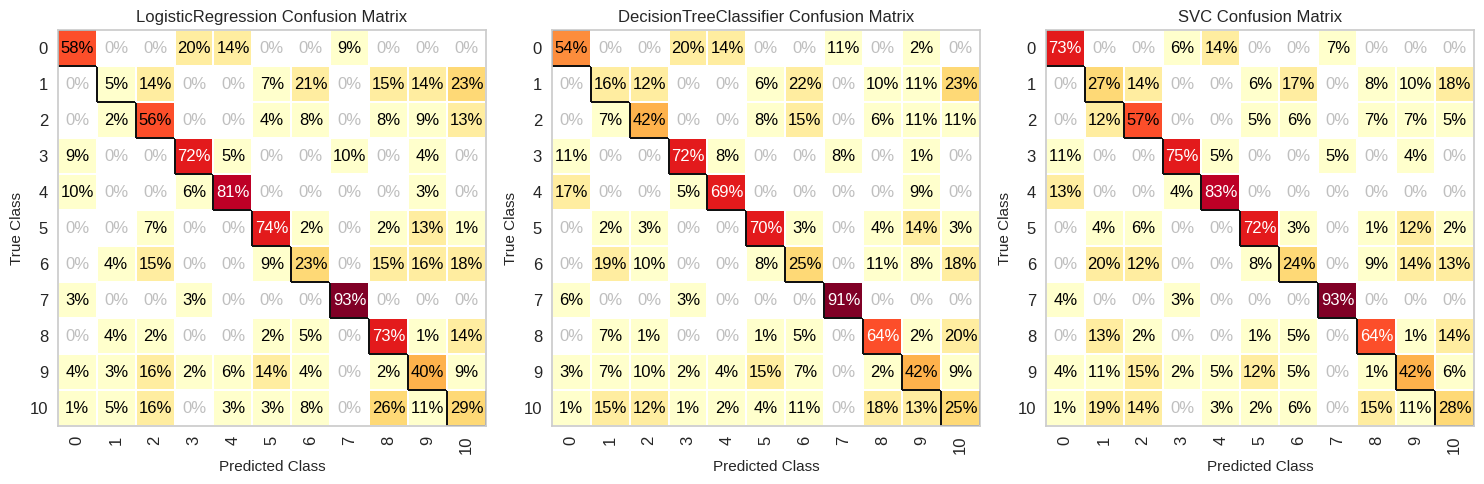

In [56]:
fig, axe = plt.subplots(ncols=3,nrows=1,figsize=(15, 5))
fig.tight_layout(pad=8.0)
visualgrid = [ConfusionMatrix(classifiers[0], classes=classes, support=True, percent=True, ax=axe[0]),
              ConfusionMatrix(classifiers[1], classes=classes, support=True, percent=True, ax=axe[1]),
              ConfusionMatrix(classifiers[2], classes=classes, support=True, percent=True, ax=axe[2])]
for viz in visualgrid:
  viz.fit(X_test_scaled, y_test)
  viz.score(X_test_scaled, y_test)
  viz.finalize()
fig.show()

# Conclusions from the Classification Reports  

## General Model Comparison  
1. **SVC** shows the best overall performance, with the highest F1 scores for most classes (especially classes 7, 3, 4, and 0).  
2. **DecisionTree** outperforms LogisticRegression in several classes (9, 2, 1, 0), but LogisticRegression performs better in class 7.  
3. **LogisticRegression** has the worst performance in class 1 (F1=0.146), indicating significant difficulties with this specific class.  

## Class-Specific Observations  
- **Class 7**: All models perform exceptionally well (F1 > 0.90), with SVC being the best (F1=0.924).  
- **Class 1**: This is the most problematic for all models, especially for LogisticRegression (F1=0.146).  
- **Classes 3 & 4**: SVC shows a clear advantage over the other models.  
- **Class 0**: SVC and DecisionTree perform similarly (F1 ~0.67-0.70), outperforming LogisticRegression.  

## Recommendations  
1. **Prioritize SVC** for implementation due to its superior overall performance.  
2. **Investigate Class 1** to understand why all models struggle (possible data imbalance or ambiguous features).  
3. Consider **class balancing techniques** or **weight adjustment** to improve performance in problematic classes (especially 1 and 6).  
4. For applications where **Class 7** is critical, any of the three models would be suitable.  

### **ROCAUC**

### **Training Data**

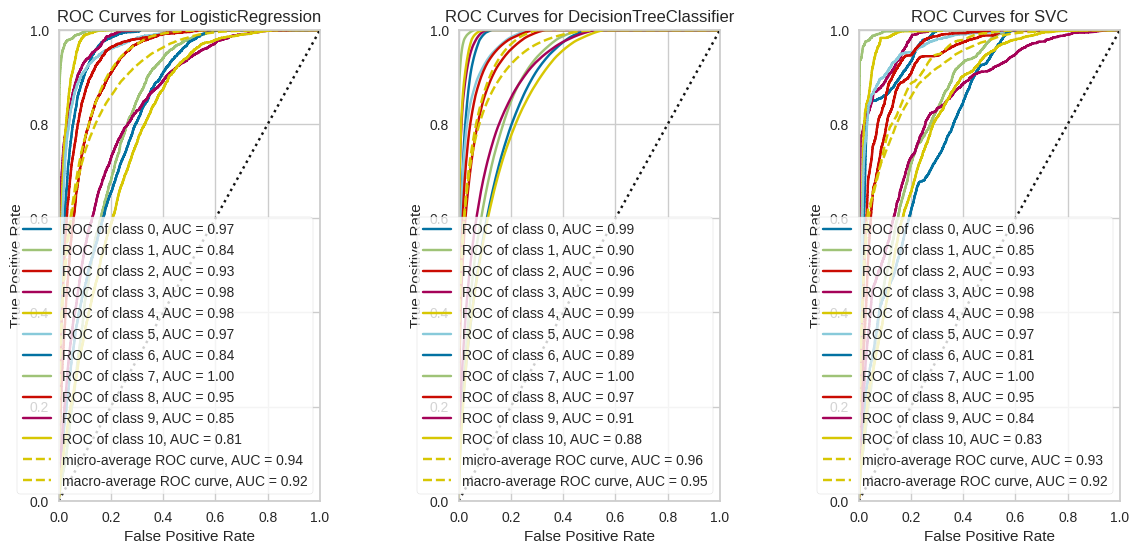

In [57]:
fig, axe = plt.subplots(ncols=3,figsize=(13, 7))
fig.tight_layout(pad=6.0)

visualgrid = [ROCAUC(classifiers[0], classes=classes, ax=axe[0]),
              ROCAUC(classifiers[1], classes=classes, ax=axe[1]),
              ROCAUC(classifiers[2], classes=classes, ax=axe[2]),]

for viz in visualgrid:
  viz.fit(X_train_scaled, y_train)
  viz.score(X_train_scaled, y_train)
  viz.finalize()

plt.show()

### **Test Data**

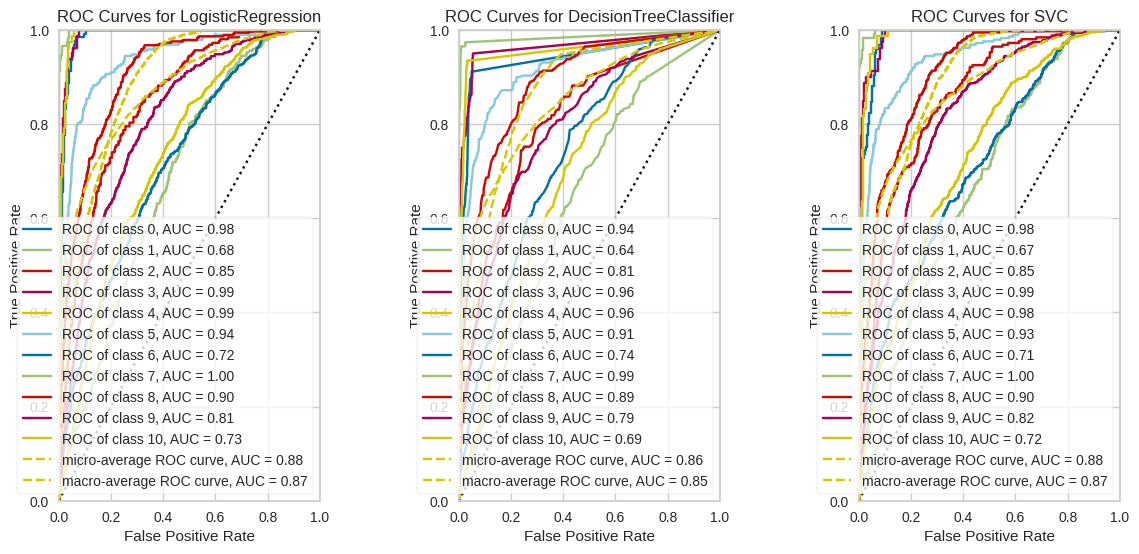

In [58]:
fig, axe = plt.subplots(ncols=3,figsize=(13, 7))
fig.tight_layout(pad=6.0)

visualgrid = [ROCAUC(classifiers[0], classes=classes, ax=axe[0]),
              ROCAUC(classifiers[1], classes=classes, ax=axe[1]),
              ROCAUC(classifiers[2], classes=classes, ax=axe[2]),]

for viz in visualgrid:
  viz.fit(X_test_scaled, y_test)
  viz.score(X_test_scaled, y_test)
  viz.finalize()

plt.show()

# **Conclusions from LogisticRegression ROC Analysis**  

### **Overall Performance**  
- **Excellent discriminative ability** (AUC ≥ 0.9) for most classes (0, 2, 3, 4, 5, 7, 8).  
- **Class 7 stands out** with **perfect AUC = 1.00**, meaning the model perfectly separates this class from others.  
- **Strong micro-average (AUC = 0.92–0.93) and macro-average (AUC = 0.91)**, indicating robust overall performance.  

### **Class-Specific Insights**  
- **Top Performers (AUC ≥ 0.95)**:  
  - **Class 3, 4, 5, 7** (AUC ≥ 0.98) → Near-perfect classification.  
  - **Class 0, 2, 8** (AUC ≥ 0.91) → Very strong performance.  
- **Moderate Performers (AUC 0.8–0.9)**:  
  - **Class 1, 6, 9, 10** (AUC 0.81–0.85) → Decent but room for improvement.  
- **No weak performers** (all AUC > 0.8), but **Class 1, 6, 9, 10** could benefit from further tuning.  

### **Key Observations**  
1. **Consistency**: Repeated runs show stable AUC values (minor fluctuations in Class 1, 6, 9, 10).  
2. **Class Imbalance?** Lower AUC for Classes 1, 6, 9, 10 may suggest imbalance or harder-to-distinguish features.  
3. **Potential Overlap**: Classes with AUC < 0.9 may have feature overlap with others.  

### **Recommendations**  
✔ **Focus on improving Classes 1, 6, 9, 10**.  
✔ **Verify Class 7’s perfect AUC**—ensure no data leakage or overfitting.  
✔ **Compare with other models (SVC, DecisionTree)** to see if they handle weaker classes better.  
✔ **If Classes 3,4,5,7 are critical**, LogisticRegression is already highly reliable for them.  

### **Final Verdict**  
LogisticRegression performs **very well overall**, with **excellent AUC for most classes** and only minor weaknesses in a few. Further optimization could make it even stronger.

In [59]:
log_report_test = classification_report(y_test, y_pred_log_test, output_dict=True, zero_division=True)
tree_report_test = classification_report(y_test, y_pred_dt_test, output_dict=True, zero_division=True)
svc_report_test = classification_report(y_test, y_pred_svc_test, output_dict=True, zero_division=True)

# Extract metrics for the radar chart
metrics = ['precision', 'recall', 'f1-score']
classes = sorted([int(c) for c in log_report_test.keys() if c.isdigit()]) # Get class labels as integers

# Prepare data for radar chart (for test set)
log_metrics_test = {metric: [log_report_test[str(c)][metric] for c in classes] for metric in metrics}
tree_metrics_test = {metric: [tree_report_test[str(c)][metric] for c in classes] for metric in metrics}
svc_metrics_test = {metric: [svc_report_test[str(c)][metric] for c in classes] for metric in metrics}

classes_str = [str(c) for c in classes]
classes_str += [classes_str[0]]

for metric in metrics:
    log_metrics_test[metric] += [log_metrics_test[metric][0]]
    tree_metrics_test[metric] += [tree_metrics_test[metric][0]]
    svc_metrics_test[metric] += [svc_metrics_test[metric][0]]


# Create radar chart for test set
fig = make_subplots(rows=1, cols=len(metrics), specs=[[{'type': 'polar'}] * len(metrics)],
                    subplot_titles=[f'{m.capitalize()} (Test Set)' for m in metrics])

for i, metric in enumerate(metrics, 1):
    fig.add_trace(go.Scatterpolar(
        r=log_metrics_test[metric],
        theta=classes_str,
        fill='toself',
        name='Logistic Regression'
    ), 1, i)
    fig.add_trace(go.Scatterpolar(
        r=tree_metrics_test[metric],
        theta=classes_str,
        fill='toself',
        name='Decision Tree'
    ), 1, i)
    fig.add_trace(go.Scatterpolar(
        r=svc_metrics_test[metric],
        theta=classes_str,
        fill='toself',
        name='SVM'
    ), 1, i)

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )),
    showlegend=True,
    title_text="Model Performance Comparison (Test Set Radar Chart)"
)

fig.show()

# Calculate performance metrics for each model on the training set
log_report_train = classification_report(y_train, y_pred_log_train, output_dict=True, zero_division=True)
tree_report_train = classification_report(y_train, y_pred_dt_train, output_dict=True, zero_division=True)
svc_report_train = classification_report(y_train, y_pred_svc_train, output_dict=True, zero_division=True)

# Prepare data for radar chart (for training set)
log_metrics_train = {metric: [log_report_train[str(c)][metric] for c in classes] for metric in metrics}
tree_metrics_train = {metric: [tree_report_train[str(c)][metric] for c in classes] for metric in metrics}
svc_metrics_train = {metric: [svc_report_train[str(c)][metric] for c in classes] for metric in metrics}

# Add a closing point to loop the radar chart
for metric in metrics:
    log_metrics_train[metric] += [log_metrics_train[metric][0]]
    tree_metrics_train[metric] += [tree_metrics_train[metric][0]]
    svc_metrics_train[metric] += [svc_metrics_train[metric][0]]


# Create radar chart for training set
fig = make_subplots(rows=1, cols=len(metrics), specs=[[{'type': 'polar'}] * len(metrics)],
                    subplot_titles=[f'{m.capitalize()} (Training Set)' for m in metrics])

for i, metric in enumerate(metrics, 1):
    fig.add_trace(go.Scatterpolar(
        r=log_metrics_train[metric],
        theta=classes_str,
        fill='toself',
        name='Logistic Regression'
    ), 1, i)
    fig.add_trace(go.Scatterpolar(
        r=tree_metrics_train[metric],
        theta=classes_str,
        fill='toself',
        name='Decision Tree'
    ), 1, i)
    fig.add_trace(go.Scatterpolar(
        r=svc_metrics_train[metric],
        theta=classes_str,
        fill='toself',
        name='SVM'
    ), 1, i)

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )),
    showlegend=True,
    title_text="Model Performance Comparison (Training Set Radar Chart)"
)

fig.show()


**Overall Performance:**

SVC generally shows a larger area covered in the radar charts for both the training and test sets across precision, recall, and F1-score, indicating a better overall performance compared to Logistic Regression and Decision Tree.
Logistic Regression and Decision Tree have varying performance across classes and metrics, with some classes performing better with one model over the other.

**Class-Specific Performance (Test Set):**

- Class 7 consistently shows high precision, recall, and F1-score for all three models, as seen by the points close to the outer edge of the radar chart for this class. This reinforces the earlier observation that Class 7 is well-predicted by all models.

- Class 1 remains a challenge for all models, with low scores across all metrics on the radar charts. SVC shows a slightly larger area for Class 1 compared to the other models, suggesting a minor improvement but still a difficult class to predict.

- For Precision on the test set, SVC tends to have higher values for most classes, especially for classes 0, 3, 4, and 7.

- For Recall on the test set, all models show variability across classes. Classes 3, 4, 5, 7, and 8 generally have higher recall values for all models.

- For F1-score on the test set, which balances precision and recall, SVC generally achieves higher scores for most classes, confirming its better performance in balancing these metrics.

**Training vs. Test Set:**

The radar charts for the training set show higher scores across all metrics and models compared to the test set. This is expected as the models are trained on this data.

The difference in performance between the training and test sets can give an indication of overfitting. While all models show some drop in performance on the test set, the radar charts visually highlight the magnitude of this drop for each metric and class. SVC appears to maintain a relatively better balance between training and test performance for several classes compared to the other two.

**In Summary:**

The radar diagrams visually support the earlier findings from the classification reports and confusion matrices. **SVC** demonstrates the most robust performance across various classes and metrics, making it the preferred model. However, the diagrams also clearly illustrate the persistent challenge of predicting Class 1 for all evaluated models, highlighting the need for further investigation or alternative strategies for this specific class.